# Filtering corpora using Quality

<a target="_blank" href="https://colab.research.google.com/github/HLasse/TextDescriptives/blob/main/docs/tutorials/filter_corpus_using_quality.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In many cases if you want to analyse tweets, train a model on text scraped from the web or similar, it is important to filter out low-quality texts.

TextDescriptives implements a series of heuristic filters for removing low-quality text. This tutorial will take you through how to use these to filter
your text corpora.

## Setup

For this we will use the [Danish Gigaword](https://sprogteknologi.dk/dataset/danish-gigaword) available on [Huggingface Datasets](DDSC/partial-danish-gigaword-no-twitter). Actually in this tutorial we will just use a small test version of it, but you could change it to use the whole dataset. A large collection of Danish texts collected from a variety of domains. To download it we will need the `datasets` package. To install it please run:

```python
!pip install datasets
```

We can now easily donwload the dataset using the following command:

In [28]:
from datasets import load_dataset

# note this can take quite a while
dataset = load_dataset("DDSC/partial-danish-gigaword-small-test-sample")

# All of the dataset is available in the train split - we can simply:
dataset = dataset["train"]

Using custom data configuration DDSC--partial-danish-gigaword-small-test-sample-6518b630de09688d
Found cached dataset parquet (/Users/au561649/.cache/huggingface/datasets/DDSC___parquet/DDSC--partial-danish-gigaword-small-test-sample-6518b630de09688d/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/1 [00:00<?, ?it/s]

In [29]:
# We can take a look at one of the examples:
ten_samples = dataset.select(range(10))
ten_samples.to_pandas()

,text,source,doc_id,LICENSE,uri,date_built
0,Den fulde tekst Pressenævnets kendelse i sag n...,retsinformationdk,retsinformationdk_173889,Danish Copyright law at https://www.retsinform...,https://www.retsinformation.dk/Forms/R0710.asp...,Fri Nov 22 00:51:31 2019 +0100
1,Resume\n\nEfter at der var sket afskedigelser ...,retsinformationdk,retsinformationdk_39059,Danish Copyright law at https://www.retsinform...,https://www.retsinformation.dk/Forms/R0710.asp...,Fri Nov 22 00:51:14 2019 +0100
2,Resume\n\nContainere kunne ikke anses som genb...,retsinformationdk,retsinformationdk_15045,Danish Copyright law at https://www.retsinform...,https://www.retsinformation.dk/Forms/R0710.asp...,Fri Nov 22 00:51:28 2019 +0100
3,Resume\n\nEn forhandler ved »home-parties« af ...,retsinformationdk,retsinformationdk_37261,Danish Copyright law at https://www.retsinform...,https://www.retsinformation.dk/Forms/R0710.asp...,Fri Nov 22 00:49:27 2019 +0100
4,Den fulde tekst\n\nSkrivelse om lov om fleksyd...,retsinformationdk,retsinformationdk_19415,Danish Copyright law at https://www.retsinform...,https://www.retsinformation.dk/Forms/R0710.asp...,Fri Nov 22 00:52:27 2019 +0100
5,Resume\n\nResumé\n\nKlage over påbud om særlig...,retsinformationdk,retsinformationdk_31217,Danish Copyright law at https://www.retsinform...,https://www.retsinformation.dk/Forms/R0710.asp...,Fri Nov 22 00:49:18 2019 +0100
6,Resume\n\nResumé\n\nI en række af de af Danmar...,retsinformationdk,retsinformationdk_14387,Danish Copyright law at https://www.retsinform...,https://www.retsinformation.dk/Forms/R0710.asp...,Fri Nov 22 00:49:49 2019 +0100
7,Oversigt (indholdsfortegnelse)\n\nBilag 1\n\nD...,retsinformationdk,retsinformationdk_166197,Danish Copyright law at https://www.retsinform...,https://www.retsinformation.dk/Forms/R0710.asp...,Fri Nov 22 00:49:44 2019 +0100
8,Den fulde tekst\n\nBekendtgørelse om afregning...,retsinformationdk,retsinformationdk_76994,Danish Copyright law at https://www.retsinform...,https://www.retsinformation.dk/Forms/R0710.asp...,Fri Nov 22 00:52:52 2019 +0100
9,Den fulde tekst Ligebehandlingsnævnets afgørel...,retsinformationdk,retsinformationdk_192325,Danish Copyright law at https://www.retsinform...,https://www.retsinformation.dk/Forms/R0710.asp...,Fri Nov 22 00:51:41 2019 +0100


As previously mentioned the Danish Gigaword consist of multiple domains. For this tutorial, we will look at three of these domains. `retsinformationdk` which consist of legal documents, `hest` which contain post from a Danish debate forum and `spont` which contains texts transcriped from spontaneous speech.

In [30]:
# we can filter out these three datasets based on the "source"
legal = dataset.filter(lambda x: x["source"] == "retsinformationdk")
news = dataset.filter(lambda x: x["source"] == "tv2r")
speech = dataset.filter(lambda x: x["source"] == "spont")

Loading cached processed dataset at /Users/au561649/.cache/huggingface/datasets/DDSC___parquet/DDSC--partial-danish-gigaword-small-test-sample-6518b630de09688d/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-beca55bc168c3e3d.arrow
Loading cached processed dataset at /Users/au561649/.cache/huggingface/datasets/DDSC___parquet/DDSC--partial-danish-gigaword-small-test-sample-6518b630de09688d/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-be9e6b466f0d4ee9.arrow
Loading cached processed dataset at /Users/au561649/.cache/huggingface/datasets/DDSC___parquet/DDSC--partial-danish-gigaword-small-test-sample-6518b630de09688d/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-56a5eac62a6adddf.arrow


We can now examine these datasets a bit more:

In [31]:
print(f"Legal contains {len(legal)} examples")
print(f"News contains {len(news)} examples")
print(f"Speech contains {len(speech)} examples")

Legal contains 1000 examples
News contains 1000 examples
Speech contains 411 examples


We can for example see that the speech dataset contains notably fewer sampels than the rest and the news and legal dataset contains 1000 samples.

# Quality Filtering
After we have prepared our datasets we can now start with the quality filtering. Using Textdescriptives this is extremely simple. We need to do 3 thing:

1) Create a pipeline
2) Add the quality component from textdescriptives to it
3) Apply the pipeline to the dataset


In [32]:
import spacy
import textdescriptives as td

# 1. Crease a blank spaCy model with a sentencizer
nlp = spacy.blank("da")
nlp.add_pipe("sentencizer")
nlp.max_length = 2000000  # as some of the documents are quite long we can increase the max length
# however it might be worth filtering out these documents before for very very long documents.

# 2. Add the textdescriptives pipeline
quality_pipe = nlp.add_pipe("textdescriptives/quality")

# 3. Apply the pipeline to the legal documents
legal_docs = nlp.pipe(legal["text"], batch_size=100, n_process=4)

If we check now we can see that legal_docs is a generator. This can be a quite efficient format, but for now we just want to process all the text so we simply need to convert it to a list:

In [33]:
legal_docs

<generator object Language.pipe at 0x40f69de40>

In [34]:
legal_docs = list(legal_docs)

We can now inspect the output here:

In [35]:
legal_doc = legal_docs[0]

print(legal_doc[:100]) # print the first 100 tokens
print("----")
print("This is pass the quality filter:")
legal_doc._.passed_quality_check

Den fulde tekst Pressenævnets kendelse i sag nr. 15-70-00822
Resumé
Foreningen for Skånsomt Kystfiskeri har ikke retlig interesse
DR bragte et radioindslag om Natur- og Erhvervsstyrelsens fiskeriinspektorats fangst af ulovlige ålefælder. Foreningen for Skånsomt Kystfiskeri klagede blandt andet med den begrundelse, at betegnelsen ” ålefælder ” er forkert, idet ålene selv kan svømme ind og ud. Pressenævnet afviser at behandle klagen, da foreningen ikke er omtalt i udsendelsen og derfor ikke har retlig interesse.
Pressenævnets formand udtaler:
Det er en betingelse for at klage til Pressenævnet, at
----
This is pass the quality filter:


False

Here we see that the text did not pass the quality filter. We can now examine why that using the following code:

In [36]:
legal_doc._.quality

{'n_stop_words': 192,
 'alpha_ratio': 0.804,
 'mean_word_length': 4.546,
 'doc_length': 500,
 'proportion_ellipsis': 0.0,
 'proportion_bullet_points': 0.0,
 'duplicate_line_chr_fraction': 0.25737766156144937,
 'duplicate_paragraph_chr_fraction': 0.0,
 'duplicate_5-gram_chr_fraction': 0.5401568920433321,
 'duplicate_6-gram_chr_fraction': 0.519237952932387,
 'duplicate_7-gram_chr_fraction': 0.519237952932387,
 'duplicate_8-gram_chr_fraction': 0.519237952932387,
 'duplicate_9-gram_chr_fraction': 0.519237952932387,
 'duplicate_10-gram_chr_fraction': 0.519237952932387,
 'top_2-gram_chr_fraction': 0.017930519237952934,
 'top_3-gram_chr_fraction': 0.042958535674262235,
 'top_4-gram_chr_fraction': 0.0653716847217034,
 'symbol_#_to_word_ratio': 0.0,
 'contains_lorem ipsum': False}

Here we see that fraction of characters which is a part of a duplicate 10 gram is >50%. This is likely the reason why the sample was filtered out. This is not uncommon for legal documents which contain a lot of standard phrases. However you might wish to change the threshold for this filter. You can see an example of how to do this in the [documentation](https://hlasse.github.io/TextDescriptives/quality.html). We also see that the `alpha_ratio` is close 0.8. This means that the text is mostly made up of alphabetic characters.

You can also inspect the existing thresholds:

In [37]:
quality_pipe.quality_thresholds

QualityThresholds(n_stop_words=(2, None), alpha_ratio=(0.6, None), mean_word_length=(3, 10), doc_length=(10, 100000), symbol_to_word_ratio={'#': (None, 0.1)}, proportion_ellipsis=(None, 0.3), proportion_bullet_points=(None, 0.8), contains={'lorem ipsum': False}, duplicate_line_chr_fraction=(None, 0.2), duplicate_paragraph_chr_fraction=(None, 0.2), duplicate_ngram_chr_fraction={'5': (None, 0.15), '6': (None, 0.14), '7': (None, 0.13), '8': (None, 0.12), '9': (None, 0.11), '10': (None, 0.1)}, top_ngram_chr_fraction={'2': (None, 0.2), '3': (None, 0.18), '4': (None, 0.16)})

Here we see that the `duplicate_ngram_chr_fraction` for 10-grams is 0.1. This means that if a text contains more than 10% of characters which are a part of a duplicate 10-gram it will be filtered out.

### Filtering out the text
Assuming we don't want to change the filter we can now use it to filter out the texts that we want to keep:

In [38]:
# 4. Filter out the documents that do not pass the quality
legal_docs_filtered = [doc for doc in legal_docs if doc._.passed_quality_check]


In [39]:
print(f"We had a total of {len(legal['text'])} which we filtered down to {len(legal_docs_filtered)}.")

We had a total of 1000 which we filtered down to 335.


That seems like a lot, we should probably check why that is. We can do this by looking at the distribution of the scores:

<AxesSubplot: ylabel='Count'>

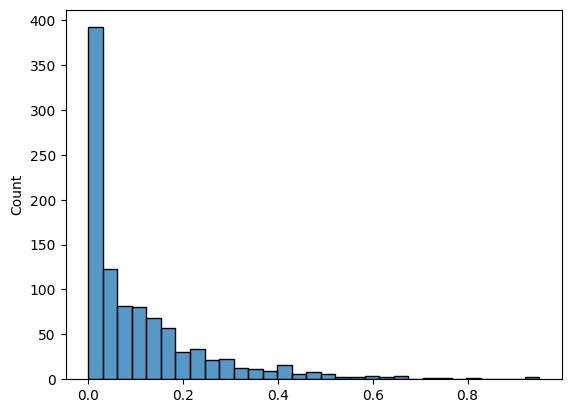

In [40]:
import seaborn as sns

duplicate_10_gram_fraction = [doc._.quality["duplicate_10-gram_chr_fraction"] for doc in legal_docs]
sns.histplot(duplicate_10_gram_fraction)

This seems fine like it explains a lot of the texts which were filtered out, but does not explain everything. Let us take a look at the `alpha_ratio` as well:

<AxesSubplot: ylabel='Count'>

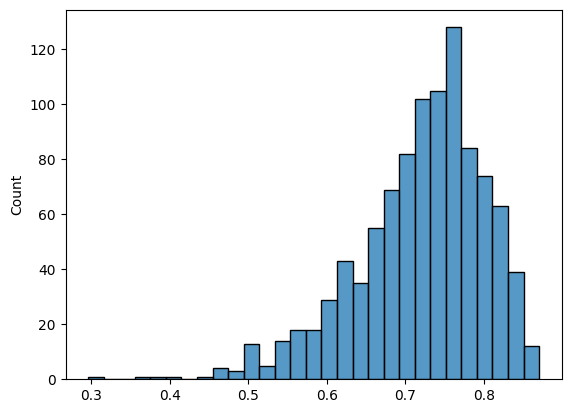

In [41]:
alpha_ratio = [doc._.quality["alpha_ratio"] for doc in legal_docs]
sns.histplot(alpha_ratio)

We see that most of the text does not pass the `alpha_ratio` filter of 0.8 or higher. This is not uncommon for legal documents as e.g. the paragraph sign `§` is not an alphabetic character. It might be relevant to change the thresholdhold to 0.7 or lower.

# Comparing across domains
We see that legal documents have quite a few perculiarities let us examine how the `alpha_ratio` behaves across different domains:

In [42]:
# first we apply the pipeline to the other domains
news_docs = nlp.pipe(news["text"], batch_size=100, n_process=4)
news_docs = list(news_docs)

In [43]:
speech_docs = nlp.pipe(speech["text"], batch_size=100, n_process=4)
speech_docs = list(speech_docs)

In [44]:
# etract alpha ratio:
news_alpha_ratio = [doc._.quality["alpha_ratio"] for doc in news_docs]
speech_alpha_ratio = [doc._.quality["alpha_ratio"] for doc in speech_docs]

Now that we have the metrics we can plot a histogram comparing the metrics:

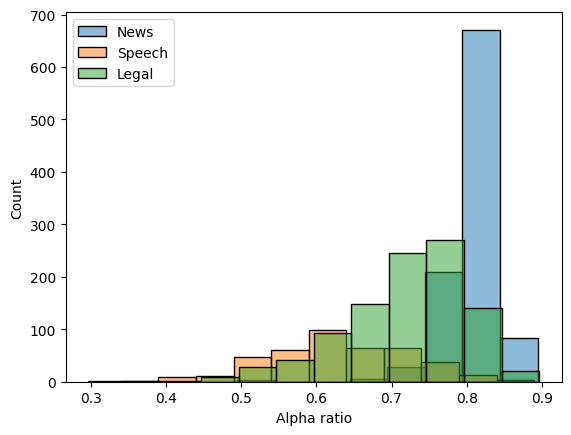

In [45]:
import matplotlib.pyplot as plt
# histogram
sns.histplot(news_alpha_ratio, label="News", alpha=0.5, binwidth=0.05)
sns.histplot(speech_alpha_ratio, label="Speech", alpha=0.5, binwidth=0.05)
sns.histplot(alpha_ratio, label="Legal", alpha=0.5, binwidth=0.05)

# add labels
plt.xlabel("Alpha ratio")
plt.ylabel("Count")
plt.legend()

Here we see a couple of things:
- Spontanous speech have a notably low alpha ratio. We should probably look into it.
- A reasonable amount of legal documents have an alpha ratio above 0.6.
- Almost no news text have a alpha ratio below 0.6.

Let us examine the spontaneous speech a bit more:

In [46]:
# Examing the first speech document
doc = speech_docs[0]
print([t for t in doc[:100]])  # print the first 100 tokens

[Taler, 6, :, mm, 
, Taler, 7, :, er, du, klar, ?, 
, Taler, 6, :, ja, 
, Taler, 7, :, så, er, spørgsmålet, om, vi, skal-, om, det, er, sådan, her, ja, det, kunne, man, godt, okay, 
, Taler, 7, :, okay, så, det, er, ignore, tab, kill, og, kill, tab, 
, Taler, 6, :, NA, 
, Taler, 6, :, kill, 
, Taler, 6, :, kill, tab, 
, Taler, 7, :, super, 
, Taler, 7, :, okay, det, er, det, hun, lige, har, sagt, 
, Taler, 6, :, ja, 
, Taler, 6, :, ja, 
, Taler, 6, :, NA]


From this we can see that a high proportion of the tokens in the speech dataset actually denotes the speeaker. This might or might not be problematic for the dataset of interesting, but it does indeed make sense that it inflates the number of tokens.

Therefore it is important to note that while these filters are useful for filtering large amount of texts it is also important to know that they should probably the adjusted to the target domain.